In [17]:
import numpy as np 
import pandas as pd

import sys
import re
from datetime import date

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error  as mse
from sklearn.metrics import mean_absolute_error  as mae
from sklearn.metrics import mean_absolute_percentage_error  as mape
from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split, KFold
from tqdm.notebook import tqdm

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor

import requests
from bs4 import BeautifulSoup
import csv

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 50) 
pd.set_option('display.max_columns', 50)

In [18]:
VERSION    = 11

VAL_SIZE   = 0.33   # 33%
N_FOLDS    = 5
RANDOM_SEED = 42

# CATBOOST
ITERATIONS = 2000
LR         = 0.1

DIR_TRAIN  = '../input/parced/'
DIR_TEST   = '../input/sf-dst-car-price/'

#### 1. Парсинг

In [19]:
# Список моделей bmw
url_models_list=[
'https://auto.ru/moskva/cars/bmw/02/used/',
'https://auto.ru/moskva/cars/bmw/1er/used/',
'https://auto.ru/moskva/cars/bmw/2er/used/',       
'https://auto.ru/moskva/cars/bmw/2activetourer/used/',
'https://auto.ru/moskva/cars/bmw/2grandtourer/used/',
'https://auto.ru/moskva/cars/bmw/2000_c_cs/used/',
'https://auto.ru/moskva/cars/bmw/3er/used/',
'https://auto.ru/moskva/cars/bmw/321/used/',
'https://auto.ru/moskva/cars/bmw/326/used/',
'https://auto.ru/moskva/cars/bmw/340/used/',
'https://auto.ru/moskva/cars/bmw/4/used/',
'https://auto.ru/moskva/cars/bmw/5er/used/',
'https://auto.ru/moskva/cars/bmw/6er/used/',
'https://auto.ru/moskva/cars/bmw/7er/used/',
'https://auto.ru/moskva/cars/bmw/8er/used/',
'https://auto.ru/moskva/cars/bmw/e3/used/',
'https://auto.ru/moskva/cars/bmw/i3/used/',
'https://auto.ru/moskva/cars/bmw/i8/used/',
'https://auto.ru/moskva/cars/bmw/m2/used/',
'https://auto.ru/moskva/cars/bmw/m3/used/',
'https://auto.ru/moskva/cars/bmw/m4/used/',
'https://auto.ru/moskva/cars/bmw/m5/used/',
'https://auto.ru/moskva/cars/bmw/m6/used/',
'https://auto.ru/moskva/cars/bmw/x1/used/',
'https://auto.ru/moskva/cars/bmw/x2/used/',
'https://auto.ru/moskva/cars/bmw/x3/used/',
'https://auto.ru/moskva/cars/bmw/x3_m/used/',
'https://auto.ru/moskva/cars/bmw/x4/used/',
'https://auto.ru/moskva/cars/bmw/x4_m/used/',
'https://auto.ru/moskva/cars/bmw/x5/used/',
'https://auto.ru/moskva/cars/bmw/x5_m/used/',
'https://auto.ru/moskva/cars/bmw/x6/used/',
'https://auto.ru/moskva/cars/bmw/x6_m/used/',
'https://auto.ru/moskva/cars/bmw/x7/used/',
'https://auto.ru/moskva/cars/bmw/z1/used/',
'https://auto.ru/moskva/cars/bmw/z3/used/',
'https://auto.ru/moskva/cars/bmw/z4/used/',
'https://auto.ru/moskva/cars/bmw/z8/used/']

In [20]:
"""
Реально здесь парсить не будем, процесс долгий

# найдем все страницы с авто - БМВ
all_pages_bmv = []
for model in url_models_list:
    for page in range(1,totalPages(model)):
        adress_i = model + "?page=" + str(page) + '&output_type=list'
        all_pages_bmv.append(adress_i)


# создадим список со всеми ссылками на каждую авто БМВ
all_url_bmv = []
for page in all_pages_bmv:
    r = requests.get(page)
    soup = BeautifulSoup(r.text, 'lxml')
    urls_car = soup.find_all('a', class_ = 'Link ListingItemTitle-module__link')
    for url_car in urls_car:
        all_url_bmv.append(url_car.get('href'))
"""

def parceFeatures(url):
    # достаем признаки
    r = requests.get(url)
    r.encoding = 'utf-8' 
    soup = BeautifulSoup(r.text, 'lxml')

    # достаем 'productionDate', делаем, через try/txcept, га случай, если признака нет
    try:
        productionDate = int(soup.find('ul', class_= "CardInfo")\
                         .find('li', class_='CardInfo__row CardInfo__row_year')\
                         .find_all('span', class_="CardInfo__cell")[-1].text)
    except:
        productionDate = ""

    # достаем 'mileage'
    try:
        mileage = soup.find('ul', class_= "CardInfo")\
                         .find('li', class_='CardInfo__row CardInfo__row_kmAge')\
                         .find_all('span', class_="CardInfo__cell")[-1].text
        mileage = int("".join(mileage.split('\xa0')[:-1:]))
    except:
        mileage = ""


    # достаем bodyType
    try:
        bodyType = soup.find('ul', class_= "CardInfo")\
                         .find('li', class_='CardInfo__row CardInfo__row_bodytype')\
                         .find_all('span', class_="CardInfo__cell")[-1].text
    except:
        bodyType = ""

    # достаем color
    try:
        color = soup.find('ul', class_= "CardInfo")\
                         .find('li', class_='CardInfo__row CardInfo__row_color')\
                         .find_all('span', class_="CardInfo__cell")[-1].text
    except:
        color = ""

    # достаем engine и характеристики 'engineDisplacement', 
    try: 
        engine = soup.find('ul', class_= "CardInfo")\
                         .find('li', class_='CardInfo__row CardInfo__row_engine')\
                         .find_all('span', class_="CardInfo__cell")[-1].text
        engine = engine.split('/')

        engineDisplacement = float(engine[0].split(' ')[0])
        enginePower = int(engine[1].split('\xa0')[0])
        fuelType = engine[2].strip()
    except:
        engineDisplacement = ""
        enginePower = ""
        fuelType = ""

    # достаем vehicleTransmission
    try:
        vehicleTransmission = soup.find('ul', class_= "CardInfo")\
                         .find('li', class_='CardInfo__row CardInfo__row_transmission')\
                         .find_all('span', class_="CardInfo__cell")[-1].text
    except:
        vehicleTransmission = ""

    # достаем Привод
    try:
        privod = soup.find('ul', class_= "CardInfo")\
                         .find('li', class_='CardInfo__row CardInfo__row_drive')\
                         .find_all('span', class_="CardInfo__cell")[-1].text
    except:
        privod = ""

    # достаем руль
    try:
        wheel = soup.find('ul', class_= "CardInfo")\
                         .find('li', class_='CardInfo__row CardInfo__row_wheel')\
                         .find_all('span', class_="CardInfo__cell")[-1].text
    except:
        wheel = ""

    # достаем состояние
    try:
        state = soup.find('ul', class_= "CardInfo")\
                         .find('li', class_='CardInfo__row CardInfo__row_state')\
                         .find_all('span', class_="CardInfo__cell")[-1].text
    except:
        state = ""

    # достаем Владельцев
    try:
        ownersCount = soup.find('ul', class_= "CardInfo")\
                         .find('li', class_='CardInfo__row CardInfo__row_ownersCount')\
                         .find_all('span', class_="CardInfo__cell")[-1].text
    except:
        ownersCount = ""

    # достаем ПТС
    try:
        pts = soup.find('ul', class_= "CardInfo")\
                         .find('li', class_='CardInfo__row CardInfo__row_pts')\
                         .find_all('span', class_="CardInfo__cell")[-1].text
    except:
        pts = ""

    # достаем Таможня
    try:
        customs = soup.find('ul', class_= "CardInfo")\
                         .find('li', class_='CardInfo__row CardInfo__row_customs')\
                         .find_all('span', class_="CardInfo__cell")[-1].text
    except:
        customs = ""

    # достаем Владение
    try:
        owningTime = soup.find('ul', class_= "CardInfo")\
                                 .find('li', class_='CardInfo__row CardInfo__row_owningTime')\
                                 .find_all('span', class_="CardInfo__cell")[-1].text
    except:
        owningTime = ""

    # достаем цену
    try:
        price = soup.find('div', class_= "PriceUsedOffer-module__container")\
                         .find('span', class_="OfferPriceCaption__price").text.split('\xa0')
        price = int("".join(price[:-1:]))
    except:
        price = ""
    
    dfForFill = pd.DataFrame(index=range(1),columns=['bodyType','color','fuelType','productionDate',
                                                     'vehicleTransmission','engineDisplacement','enginePower',
                                                     'mileage','Привод','Руль','Состояние','Владельцы',
                                                     'ПТС','Таможня','Владение','Price'])
    dfForFill[['bodyType','color','fuelType','productionDate','vehicleTransmission',
           'engineDisplacement','enginePower','mileage','Привод','Руль','Состояние', 'Владельцы',
           'ПТС','Таможня','Владение','Price']] = \
            bodyType, color, fuelType, productionDate, vehicleTransmission,\
            engineDisplacement, enginePower, mileage, privod, wheel, state, ownersCount,\
            pts, customs, owningTime, price
    
    return dfForFill

"""
for i in range(len(dfForTraining),len(all_url_bmv)):
    if i%100==0:
        print(i)    
    dfForTraining = dfForTraining.append(parceFeatures(all_url_bmv[i]), ignore_index=True)
    if i %500 ==0:
        dfForTraining.to_csv(('parced_features part'+str(i)+'.csv'),encoding='utf-8-sig', index=False)

dfForTraining = pd.DataFrame(columns=['bodyType','color','fuelType','productionDate',
                                      'vehicleTransmission','engineDisplacement','enginePower',
                                      'mileage','Привод','Руль','Состояние','Владельцы',
                                      'ПТС','Таможня','Владение','Price'])


# сохраним полученный итоговый результат
dfForTraining.to_csv('final_parced_features.csv',encoding='utf-8-sig', index=False)
"""

"\nfor i in range(len(dfForTraining),len(all_url_bmv)):\n    if i%100==0:\n        print(i)    \n    dfForTraining = dfForTraining.append(parceFeatures(all_url_bmv[i]), ignore_index=True)\n    if i %500 ==0:\n        dfForTraining.to_csv(('parced_features part'+str(i)+'.csv'),encoding='utf-8-sig', index=False)\n\ndfForTraining = pd.DataFrame(columns=['bodyType','color','fuelType','productionDate',\n                                      'vehicleTransmission','engineDisplacement','enginePower',\n                                      'mileage','Привод','Руль','Состояние','Владельцы',\n                                      'ПТС','Таможня','Владение','Price'])\n\n\n# сохраним полученный итоговый результат\ndfForTraining.to_csv('final_parced_features.csv',encoding='utf-8-sig', index=False)\n"

In [104]:
#train = pd.read_csv(r'final_parced_features.csv') # мой подготовленный датасет для обучения модели
test = pd.read_csv(r'test.csv')
sample_submission = pd.read_csv(r'sample_submission.csv')


train = pd.read_csv(r'new_data_99_06_03_13_04.csv')
train = train[train['brand'] == 'BMW']


transmission = {
    'AUTOMATIC' : 'автоматическая', 
    'MECHANICAL' : 'механическая',
    'ROBOT' : 'роботизированная'
    }
train['vehicleTransmission'] = train['vehicleConfiguration'].apply(lambda x: transmission[x])


train.drop(['Unnamed: 0', 'brand', 'name', 'vehicleConfiguration', 'description', 'engineDisplacement'], axis=1, inplace=True)

train.head(2)
# color  modelDate numberOfDoors

,bodyType,color,fuelType,modelDate,numberOfDoors,productionDate,enginePower,mileage,Комплектация,Привод,Руль,Владельцы,ПТС,Таможня,Владение,Price,vehicleTransmission
4760,Хэтчбек 5 дв.,040001,бензин,2007.0,5.0,2008,115.0,115000,{'id': '0'},задний,LEFT,2.0,ORIGINAL,True,NaN,436000,автоматическая
4761,Хэтчбек 5 дв.,040001,бензин,2007.0,5.0,2011,115.0,39728,"{'id': '2430196', 'name': '116', 'available_op...",задний,LEFT,1.0,ORIGINAL,True,"{'year': 2011, 'month': 4}",595000,автоматическая


In [105]:
# для дальнейшей обработки соединим train test
train['id'] = np.nan
# уберем лишние колонки
for i in test.columns: 
    if i not in train.columns:
        test.drop([i], axis=1, inplace=True)

train = train[train['Price'].notna()] # уберем строки, где нет цен
data = pd.concat([train, test])

# preprocessing
data['fuelType'] = data['fuelType'].apply(lambda x: str(x).lower())
data['fuelType'] = data['fuelType'].apply(lambda x: 'бензин' if x=='nan' else x) # пропуски заполним самым частым значением
#data['engineDisplacement'] = data['engineDisplacement'].fillna(2.0) # Объем двигателя. пропуски заменим на самый частый - 2.0
#data['engineDisplacement'] = data['engineDisplacement'].apply(lambda x: 2.0 if x=='undefined LTR' else float(str(x)[:3])) # уберем лишнее
data['enginePower'] = data['enginePower'].apply(lambda x: x if type(x)==float else int(re.search('\d+', x)[0])) # возьмем только цифры для лошадок
data['enginePower'] = data['enginePower'].fillna(data['enginePower'].median()) # пропуски заменим медианой
data = data[~(data['Руль']=='Правый')] # уберем руль, он всего один правый, остальные - левые (вместе со строкой удалим)
data.drop(['Руль'], axis=1, inplace=True) 
# data.drop(['Состояние'], axis=1, inplace=True) # Состояние везде не требует ремонта
data['Владельцы'] = data['Владельцы'].fillna('3 или более') # Владелт=ьцы заполним замым частым
data.drop(['Таможня'], axis=1, inplace=True) # все растаможены
data.drop(['Владение'], axis=1, inplace=True) # слишком мало данных 4к из 10к

data['Price'] = data['Price'].apply(lambda x: np.log(x)) # сгладим цены, главное в предикте потом вернуть!!!




data['Владельцы'] = data['Владельцы'].apply(lambda x: x if type(x)==float else float(re.search('\d+', x)[0]))
data['ПТС'] = data['ПТС'].map({'DUPLICATE':'Дубликат', 'ORIGINAL':'Оригинал'})
data['color'] = data['color'].map({'CACECB': 'серебристый', 'FAFBFB':'белый', 'EE1D19':'красный', '97948F':'серый', 
                                     '660099':'пурпурный', '040001':'чёрный','4A2197':'фиолетовый', 
                                     '200204':'коричневый','0000CC':'синий', '007F00':'зелёный', 'C49648':'бежевый',
                                     '22A0F8':'голубой','DEA522':'золотистый','FFD600': 'жёлтый', 'FF8649':'оранжевый',
                                     'FFC0CB':'розовый'})
data['bodyType'] = data['bodyType'].apply(lambda x: str(x).lower())
data.drop(['Комплектация'], axis=1, inplace=True)


data.sample(2)

,bodyType,color,fuelType,modelDate,numberOfDoors,productionDate,enginePower,mileage,Привод,Владельцы,ПТС,Price,vehicleTransmission,id
9519,внедорожник 5 дв.,синий,бензин,2012.0,5.0,2014.0,184.0,120000.0,полный,3.0,Оригинал,13.845069,автоматическая,NaN
75876,внедорожник 5 дв.,синий,бензин,2014.0,5.0,2016.0,245.0,68637.0,полный,1.0,Оригинал,14.454729,автоматическая,NaN


In [106]:
data['Владельцы'].value_counts()

3.0    7841
1.0    5384
2.0    5002
Name: Владельцы, dtype: int64

#### 2. EDA 

In [107]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18227 entries, 4760 to 3836
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bodyType             18227 non-null  object 
 1   color                14390 non-null  object 
 2   fuelType             18227 non-null  object 
 3   modelDate            18227 non-null  float64
 4   numberOfDoors        18227 non-null  float64
 5   productionDate       18227 non-null  float64
 6   enginePower          18227 non-null  float64
 7   mileage              18227 non-null  float64
 8   Привод               18227 non-null  object 
 9   Владельцы            18227 non-null  float64
 10  ПТС                  14390 non-null  object 
 11  Price                14390 non-null  float64
 12  vehicleTransmission  18227 non-null  object 
 13  id                   3837 non-null   float64
dtypes: float64(8), object(6)
memory usage: 2.1+ MB


Разделим признаки на цифровые и категориальные.  
Цифровые  
'productionDate' - дата производства  
'engineDisplacement' - объем движка  
'enginePower' - лошадки  
'mileage' - пробег  
  
Категориальные  
'bodyType' - тип кузова (седан/хэтчбэк и т.д.)  
'color - цвет  
'fuelType' - тип топлива  
'vehicleTransmission' коробка (автомат/механика/робот)  
'Привод' - тут понятно (полный, задний, передний)  
'ПТС' - оригинал/дубликат 
'Владельцы' - количество владельцев по ПТС   

'Price' - целевая переменная  
'id' - порядковый номер только в тестовой выборке

In [108]:
cat_features = ['bodyType', 'color', 'fuelType', 'vehicleTransmission', 'Привод', 'Владельцы', 'ПТС']
num_features = ['productionDate', 'engineDisplacement', 'enginePower', 'mileage']

Посмотрим на цифровые признаки  
'productionDate'

<AxesSubplot:>

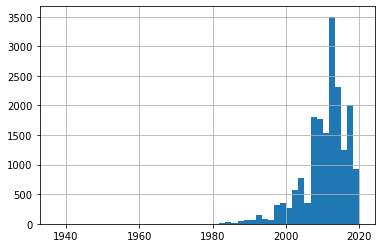

In [109]:
data['productionDate'].hist(bins=50)

<AxesSubplot:>

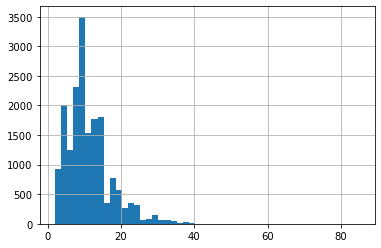

In [110]:
# переведем дату производства в возраст машины и посмотрим выбросы
data['years_old'] = date.today().year - data['productionDate']
# и добавим признак разности между датой производства и датой выпуска модели
data['model_old'] = data['productionDate'] - data['modelDate']

# уберем столбец с годом производства
data.drop(['productionDate', 'modelDate'], axis=1, inplace=True)
data['years_old'].hist(bins=50)

<AxesSubplot:>

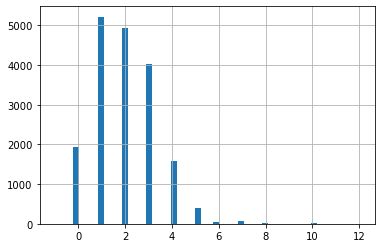

In [111]:
data['model_old'].hist(bins=50) 

<AxesSubplot:>

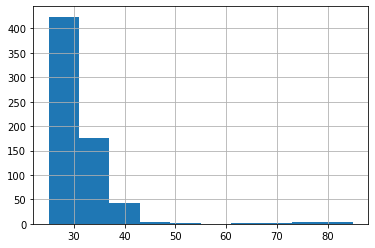

In [112]:
perc_25 = data['years_old'].quantile(0.25)
perc_75 = data['years_old'].quantile(0.75)
IQR = perc_75 - perc_25

# посмотрим сколько авто идет в выбросы по межквартильному расстоянию
data[data['years_old'] > perc_75+IQR*1.5]['years_old'].hist()

In [113]:
# Посмотрим какой вораст наибольший в валидационной выборке, где нужно будет делать предсказание
data[(data['id']>0)]['years_old'].max()

41.0

<AxesSubplot:>

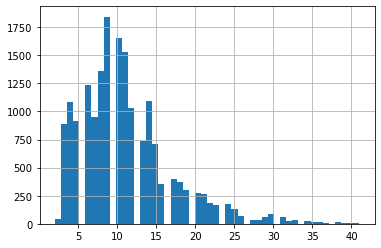

In [114]:
# выбросим всех, кто старше 41
data = data[~(data['years_old'] > 41)]
data['years_old'].hist(bins=50)

Следущий признак 'engineDisplacement'

In [115]:
# data['engineDisplacement'].hist(bins=20)

Видно преобладание 2-х и 3-х литровых двигателей. Можно посмотреть на цедесообразность отнесения данного признака к категориальным

Следущий признак 'engineDisplacement'

<AxesSubplot:>

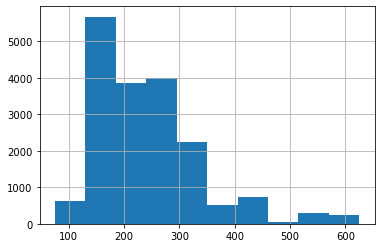

In [116]:
data['enginePower'].hist(bins=10)

<AxesSubplot:>

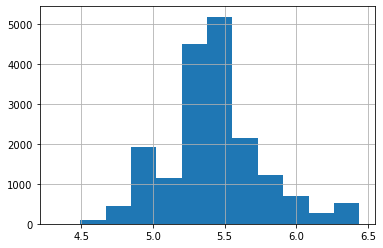

In [117]:
# сгладим данные логарифмом
data['enginePower'] = np.log(data['enginePower'])
data['enginePower'].hist(bins=12)

Следущий признак 'mileage'

<AxesSubplot:>

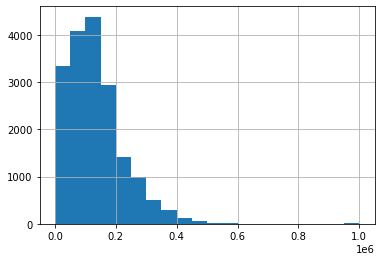

In [118]:
data['mileage'].hist(bins=20)

In [119]:
perc_25 = data['mileage'].quantile(0.25)
perc_75 = data['mileage'].quantile(0.75)
IQR = perc_75 - perc_25

# посмотрим сколько авто идет в выбросы по межквартильному расстоянию
data[data['mileage'] > perc_75+IQR*1.5]

,bodyType,color,fuelType,numberOfDoors,enginePower,mileage,Привод,Владельцы,ПТС,Price,vehicleTransmission,id,years_old,model_old
5072,хэтчбек 5 дв.,чёрный,бензин,5.0,4.859812,354000.0,задний,3.0,Оригинал,12.644328,автоматическая,NaN,17.0,1.0
5204,хэтчбек 3 дв. compact,серый,бензин,3.0,4.744932,360000.0,задний,3.0,Дубликат,11.918391,механическая,NaN,19.0,2.0
5211,универсал 5 дв.,серый,дизель,5.0,5.010635,496000.0,задний,3.0,Оригинал,12.992255,механическая,NaN,17.0,4.0
5402,универсал 5 дв.,серебристый,дизель,5.0,5.010635,397800.0,задний,3.0,Оригинал,12.899220,автоматическая,NaN,18.0,3.0
5539,хэтчбек 3 дв. compact,серебристый,бензин,3.0,4.941642,350000.0,задний,3.0,Оригинал,11.461632,механическая,NaN,25.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3504,универсал 5 дв.,NaN,дизель,5.0,5.459586,360000.0,задний,3.0,NaN,NaN,автоматическая,3504.0,15.0,0.0
3573,внедорожник 5 дв.,NaN,бензин,5.0,5.768321,350000.0,полный,3.0,NaN,NaN,автоматическая,3573.0,18.0,1.0
3651,внедорожник 5 дв.,NaN,бензин,5.0,5.849325,380000.0,полный,3.0,NaN,NaN,автоматическая,3651.0,20.0,3.0
3713,седан,NaN,бензин,4.0,5.010635,520416.0,задний,3.0,NaN,NaN,механическая,3713.0,27.0,8.0


выбросы убирать не будем, так как большинство в валидационной выборке

In [120]:
num_features = ['years_old', 'model_old', 'enginePower', 'mileage', 'numberOfDoors', 'Владельцы']
data[num_features].corr()

,years_old,model_old,enginePower,mileage,numberOfDoors,Владельцы
years_old,1.000000,0.127322,-0.195703,0.786089,-0.128049,0.560280
model_old,0.127322,1.000000,-0.144326,0.079554,-0.026299,-0.000850
enginePower,-0.195703,-0.144326,1.000000,-0.172510,0.079707,-0.066463
mileage,0.786089,0.079554,-0.172510,1.000000,-0.026826,0.516059
numberOfDoors,-0.128049,-0.026299,0.079707,-0.026826,1.000000,-0.119631
Владельцы,0.560280,-0.000850,-0.066463,0.516059,-0.119631,1.000000


Видим логичную высокую корреляцию:  
- чем старше авто, тем выше пробег  
- чем больше двигатель, тем он мощнее

#### Теперь перейдем к категориальным признакам

In [121]:
cat_features = ['bodyType', 'color', 'fuelType', 'vehicleTransmission', 'Привод', 'ПТС']

In [122]:
#Посмотрим боксплоты
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y='Price', 
                data=data.loc[data.loc[:, column].isin(data.loc[:, column].value_counts().index[:10])],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

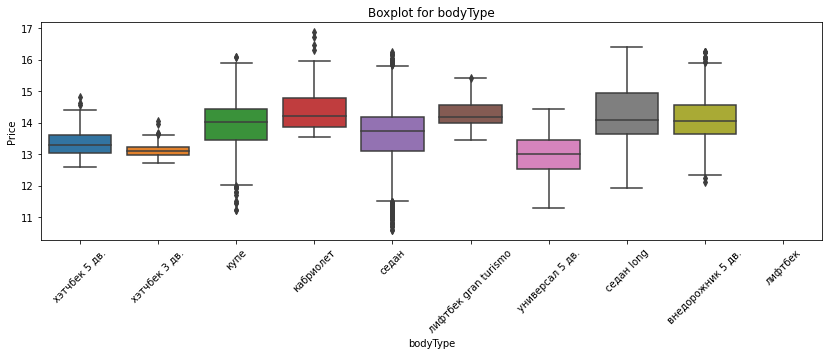

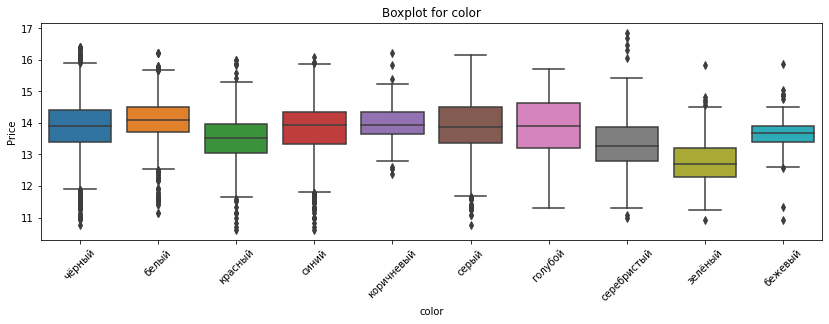

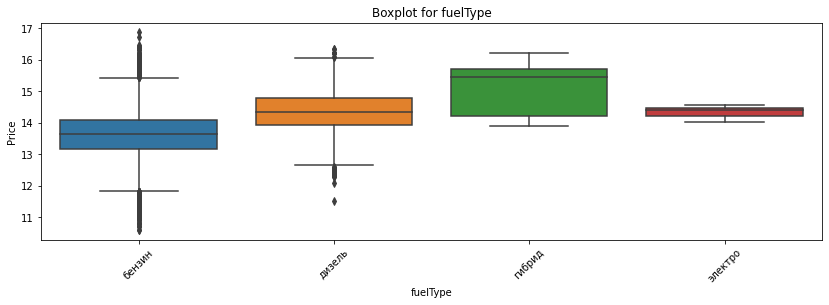

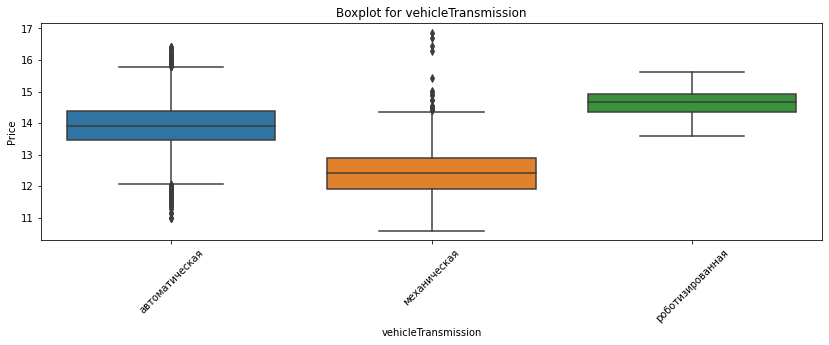

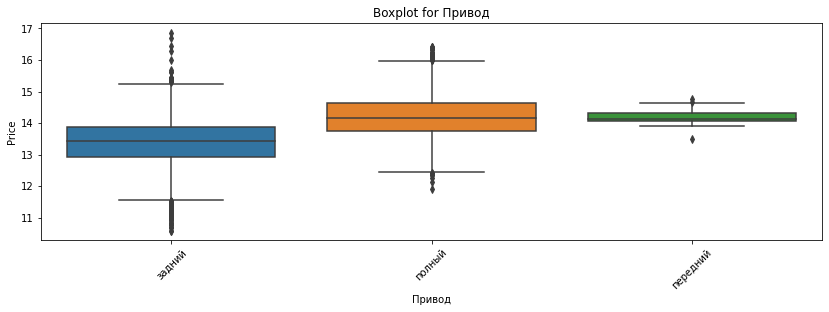

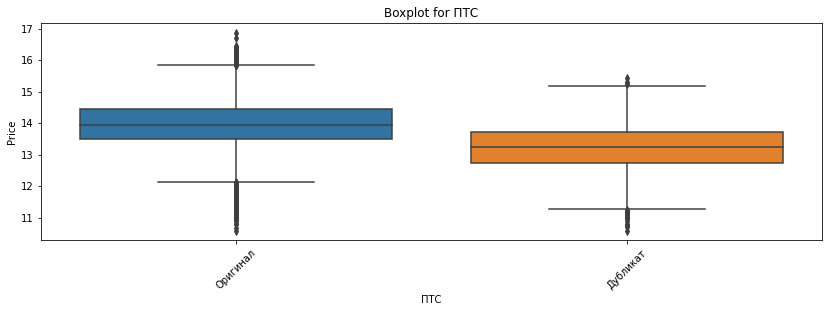

In [123]:
for col in cat_features:
    get_boxplot(col)

По графикам похоже, что все параметры могут влиять на цену (нельзя убрать только тип двигателя - электро, так как он в валидационной выборке)

#### 3. Prediction

In [124]:
# разобьем категориальные признаки (get_dummies)
for category in cat_features:
    one_hot = pd.get_dummies(data[category])
    data = pd.concat([data, one_hot], axis=1, join='inner')
    data.drop([category], axis=1, inplace=True)

In [126]:
X_valid = data[data['id'] >= 0].drop(['Price', 'id'], axis=1)

X = data[~(data['id'] >= 0)].drop(['Price', 'id'], axis=1)
y = data[~(data['id'] >= 0)]['Price']


scaler = MinMaxScaler()
X[num_features] = scaler.fit_transform(X[num_features])
X_valid[num_features] = scaler.fit_transform(X_valid[num_features])

In [127]:

VAL_SIZE   = 0.33
N_FOLDS    = 10

# CATBOOST
ITERATIONS = 4000
LR         = 0.05

RANDOM_SEED = 42
VERSION=3

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size = VAL_SIZE, random_state=RANDOM_SEED)

In [128]:
def get_params(regressor, X, y):
    # подбираем оптимальные параметры
    n_estimators = [int(x) for x in np.linspace(start=100, stop=4000, num=100)]
    max_features =  ['auto', 'sqrt']
    max_depth = [int(x) for x in np.linspace(start=10, stop=110, num=11)]
    max_depth.append(None)
    min_samples_split = [int(x) for x in np.linspace(start=2, stop=10, num=1)]
    min_samples_leaf = [1, 2, 4, 6, 8]
    bootstrap = [True, False]

    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap
                   }

    X_train = X
    y_train = y

    # подбор оптимальных параметров
    rfr = RandomizedSearchCV(estimator=regressor, param_distributions=random_grid, n_iter=100, cv=10, verbose=2, random_state=42, n_jobs=-1)
    rfr.fit(X_train, y_train)

    return rfr.best_params_

In [129]:
params = get_params(RandomForestRegressor(), X_train, y_train)
rfr_model = RandomForestRegressor(**params)
rfr_model.fit(X_train, y_train)

y_pred = rfr_model.predict(X_test)

print('MSE : ', mse(y_pred, y_test), 'MAE : ', mae(y_pred, y_test), 'MAPE : ', mape(y_pred, y_test))
print('='*30)
print(r2_score(y_pred, y_test))

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
MSE :  0.03769493658456221 MAE :  0.12114080705289484 MAPE :  0.00892163405686705
0.940736613637893


In [130]:
params

{'n_estimators': 2148,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 40,
 'bootstrap': True}

In [131]:
y_valid = rfr_model.predict(X_valid)
y_valid = np.round(np.exp(y_valid)/1000)*1000
y_valid

array([1769000., 1523000., 1484000., ...,  558000., 1098000., 1146000.])

In [132]:
submission = pd.DataFrame()
submission['Price'] = y_valid
submission['id'] = submission.index
submission = submission.reindex(columns=['id', 'Price'])
submission.to_csv(r'rfr_submission.csv', index=False)

In [133]:
# Попробуем другой подход

cbr_model = CatBoostRegressor(iterations = 5000,
                          depth=10,
                          #learning_rate = 0.5,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
                          )
cbr_model.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         )

Learning rate set to 0.027224
0:	learn: 0.0428874	test: 0.0471039	best: 0.0471039 (0)	total: 162ms	remaining: 13m 28s
100:	learn: 0.0108176	test: 0.0121920	best: 0.0121920 (100)	total: 1.62s	remaining: 1m 18s
200:	learn: 0.0093107	test: 0.0104785	best: 0.0104785 (200)	total: 2.99s	remaining: 1m 11s
300:	learn: 0.0088398	test: 0.0101389	best: 0.0101389 (300)	total: 4.36s	remaining: 1m 8s
400:	learn: 0.0084620	test: 0.0099419	best: 0.0099419 (400)	total: 5.73s	remaining: 1m 5s
500:	learn: 0.0081361	test: 0.0097617	best: 0.0097617 (500)	total: 7.13s	remaining: 1m 4s
600:	learn: 0.0078571	test: 0.0096183	best: 0.0096183 (600)	total: 8.5s	remaining: 1m 2s
700:	learn: 0.0076071	test: 0.0095017	best: 0.0095017 (700)	total: 9.86s	remaining: 1m
800:	learn: 0.0073770	test: 0.0094027	best: 0.0094027 (800)	total: 11.2s	remaining: 58.9s
900:	learn: 0.0071896	test: 0.0093374	best: 0.0093371 (899)	total: 12.6s	remaining: 57.5s
1000:	learn: 0.0069856	test: 0.0092671	best: 0.0092671 (1000)	total: 14s	r

In [134]:
y_pred = cbr_model.predict(X_test)

print('MSE : ', mse(y_pred, y_test), 'MAE : ', mae(y_pred, y_test), 'MAPE : ', mape(y_pred, y_test))
print('='*30)
print(r2_score(y_pred, y_test))

MSE :  0.035871029042147624 MAE :  0.11648560908378201 MAPE :  0.008589312123262355
0.9444206926262573


In [135]:
y_valid = cbr_model.predict(X_valid)
y_valid = np.round(np.exp(y_valid)/1000)*1000
y_valid

array([1701000., 2065000., 1411000., ...,  588000.,  969000., 1254000.])

In [136]:
submission = pd.DataFrame()
submission['Price'] = y_valid
submission['id'] = submission.index
submission = submission.reindex(columns=['id', 'Price'])
submission.to_csv(r'cbr_submission.csv', index=False)

In [139]:
models = [RandomForestRegressor(**params),
         BaggingRegressor(ExtraTreeRegressor(random_state=RANDOM_SEED), random_state=RANDOM_SEED),
         CatBoostRegressor(iterations = 5000,
                          depth=10,
                          #learning_rate = 0.5,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
                          random_state=RANDOM_SEED, verbose=False)]

def stacking_model_predict(models, X, y, X_sub, sample_submission):
    for model_ in tqdm(models):
        model_.fit(X, y)
        pred_subm = model_.predict(X_sub)
        
        sample_submission[str(model_)[:6]] = pred_subm
        sample_submission[str(model_)[:6]] = sample_submission[str(model_)[:6]].apply(lambda x: np.exp(x) )
        sample_submission[str(model_)[:6]] = sample_submission[str(model_)[:6]].apply(lambda x: round(x/1000)*1000)
    
    sample_submission['price'] = sample_submission.iloc[:,2:].mean(axis=1)
    sample_submission['price'] = sample_submission['price'].apply(lambda x: round(x/1000)*1000)
    sample_submission[['id', 'price']].to_csv(f'staking_submission.csv', index=False)

    return sample_submission[['id', 'price']]


example = stacking_model_predict(models, X, y, X_valid, sample_submission)